# Galaxy - All products
* StelllarAlgo Data Science
* Ryan Kazmerik & Nakisa Rad
* Jan 24, 2022

## Hypothesis

## Experiment
This section details our experiment including querying data, data transformations, feature selection and modelling.

In [19]:
import getpass
import pyodbc
import pandas as pd
import warnings
import matplotlib.pyplot as plt

from pycaret.classification import *

warnings.filterwarnings('ignore')

### Let's connect to MSSQL and run a stored proc to get our dataset:

In [20]:
# connect to SQL Server.
SERVER = '34.206.73.189' 
DATABASE = 'datascience' 
USERNAME = 'nrad' 
PASSWORD = getpass.getpass(prompt='Enter your password')
CNXN = pyodbc.connect('DRIVER={ODBC Driver 17 for SQL Server};SERVER='+SERVER+';DATABASE='+DATABASE+';UID='+USERNAME+';PWD='+ PASSWORD)

In [21]:
lkupclientid = 6 # Galaxy
cursor = CNXN.cursor()

storedProc = (
    f"""Exec [stlrMLS].[ds].[getRetentionScoringModelData] {lkupclientid}"""
)

df = pd.read_sql(storedProc, CNXN)

# apply some data transformations
df["year"] = pd.to_numeric(df["year"])

CNXN.commit()
cursor.close()

df.shape

(25742, 54)

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25742 entries, 0 to 25741
Data columns (total 54 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   lkupClientId            25742 non-null  int64  
 1   dimCustomerMasterId     25742 non-null  int64  
 2   customerNumber          25742 non-null  object 
 3   year                    25742 non-null  int64  
 4   productGrouping         25742 non-null  object 
 5   totalSpent              25742 non-null  float64
 6   recentDate              25742 non-null  object 
 7   attendancePercent       25742 non-null  float64
 8   renewedBeforeDays       25429 non-null  float64
 9   isBuyer                 25742 non-null  object 
 10  source_tenure           25429 non-null  float64
 11  tenure                  25429 non-null  float64
 12  distToVenue             25742 non-null  float64
 13  totalGames              25742 non-null  int64  
 14  recency                 25742 non-null

### We should specify the features used in our model:

In [23]:
# choose the features for the stellar base retention model
features = [
    "dimCustomerMasterId",
    "recency",
    "attendancePercent",
    "totalSpent",
    "distToVenue",
    "source_tenure",
    "renewedBeforeDays",
    "missed_games_1",
    "missed_games_2",
    "missed_games_over_2",
    "clickToOpenRatio",
    "clickToSendRatio",
    "openToSendRatio",
    "isNextYear_Buyer",
    "year",
    "productGrouping"
]

# copy your main dataframe
df_dataset = df

# choose the features & train year & test year
df_dataset = df_dataset[features]
df_dataset["year"] = pd.to_numeric(df_dataset["year"])
df_dataset = df_dataset.loc[df_dataset["year"] <= 2019]

df_train = df_dataset.sample(frac=0.85, random_state=786)
df_eval = df_dataset.drop(df_train.index)

df_train.reset_index(drop=True, inplace=True)
df_eval.reset_index(drop=True, inplace=True)

# print out the number of records for training and eval
print('Data for Modeling: ' + str(df_train.shape))
print('Unseen Data For Predictions: ' + str(df_eval.shape), end="\n\n")

Data for Modeling: (14111, 16)
Unseen Data For Predictions: (2490, 16)



### Now we can model the data using a binary classification prediction for the isnextyear_buyer field to see how likely a customer is to re-purchase.

In [24]:
setup(
    data= df_train, 
    target="isNextYear_Buyer", 
    train_size = 0.85,
    data_split_shuffle=True,
    ignore_features=["dimCustomerMasterId","productGrouping","year"],
    silent=True,
    verbose=False,
    numeric_features=[
    "recency",
    "attendancePercent",
    "totalSpent",
    "distToVenue",
    "source_tenure",
    "renewedBeforeDays",
    "missed_games_1",
    "missed_games_2",
    "missed_games_over_2",
    "clickToOpenRatio",
    "clickToSendRatio",
    "openToSendRatio"
    ]
);

In [25]:
model_matrix = compare_models(
    fold=10,
    include=["lr", "xgboost"]
)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
xgboost,Extreme Gradient Boosting,0.7715,0.8342,0.8426,0.7819,0.8110,0.5230,0.5255,0.5920
lr,Logistic Regression,0.7291,0.7863,0.8237,0.7404,0.7797,0.4306,0.4350,0.2210


In [26]:
best_model = create_model(model_matrix)
final_model = finalize_model(best_model)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7750,0.8416,0.8526,0.7811,0.8153,0.5289,0.5322
1,0.7600,0.8277,0.8381,0.7697,0.8025,0.4981,0.5011
2,0.7808,0.8494,0.8496,0.7896,0.8185,0.5429,0.5452
3,0.7742,0.8399,0.8596,0.7762,0.8158,0.5260,0.5306
4,0.7765,0.8420,0.8539,0.7822,0.8164,0.5321,0.5355
5,0.7673,0.8282,0.8266,0.7850,0.8053,0.5167,0.5177
6,0.7715,0.8343,0.8381,0.7842,0.8102,0.5238,0.5257
7,0.7540,0.8016,0.8381,0.7627,0.7986,0.4842,0.4878
8,0.7765,0.8386,0.8352,0.7921,0.8131,0.5356,0.5368
9,0.7790,0.8388,0.8338,0.7962,0.8146,0.5414,0.5423


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Py

### Let's load in our 2021 season data and get retention scores using the model:

In [27]:
df_inference = df.loc[df["year"] >= 2021]
df_inference = df_inference[df_inference["productGrouping"] ==  'Full Season' ]
df_inference = df_inference.fillna(0)
df_inference.shape

(2887, 54)

In [28]:
new_predictions = predict_model(final_model, data=df_inference, raw_score=True)
new_predictions.head()

,lkupClientId,dimCustomerMasterId,customerNumber,year,productGrouping,totalSpent,recentDate,attendancePercent,renewedBeforeDays,isBuyer,...,education,urbanicity,credits_after_refund,is_Lockdown,NumberofGamesPerSeason,CNTPostponedGames,isNextYear_Buyer,Label,Score_0,Score_1
20811,6,450019493,98920122,2021,Full Season,461.5,2021-11-07,0.750000,290.0,TRUE,...,Completed High School,0,0.0,1,24,0,0,0,0.6336,0.3664
20812,6,450019565,9228651,2021,Full Season,585.0,2021-11-07,1.083333,290.0,TRUE,...,Completed High School,0,0.0,1,24,0,1,1,0.0154,0.9846
20813,6,450019566,20769777,2021,Full Season,3081.0,2021-11-07,1.000000,290.0,TRUE,...,Completed High School,0,0.0,1,24,0,1,1,0.0090,0.9910
20814,6,450019977,8036052,2021,Full Season,0.0,1970-01-01,0.000000,0.0,FALSE,...,Completed High School,0,0.0,1,24,0,1,0,0.9992,0.0008
20815,6,450020766,"8238647, 68989503",2021,Full Season,3575.0,2021-11-07,0.864583,290.0,TRUE,...,Completed College,0,0.0,1,24,0,1,1,0.2211,0.7789


In [29]:
new_predictions["Label"].value_counts()

1    2446
0     441
Name: Label, dtype: int64

In [30]:
new_predictions["Score_1"].value_counts(bins=[0, 0.2, 0.4, 0.6, 0.8, 1.0])

(0.8, 1.0]       1645
(0.6, 0.8]        614
(0.4, 0.6]        295
(0.2, 0.4]        175
(-0.001, 0.2]     158
Name: Score_1, dtype: int64

array([[<AxesSubplot:title={'center':'Score_1'}>]], dtype=object)

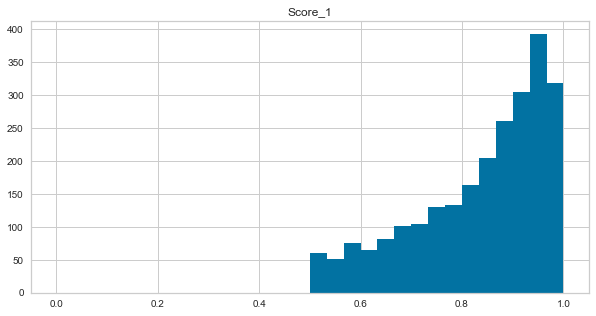

In [31]:
new_predictions[new_predictions["Label"]==1][["Score_1"]].hist(bins=30, figsize=(10,5), range=[0,1])

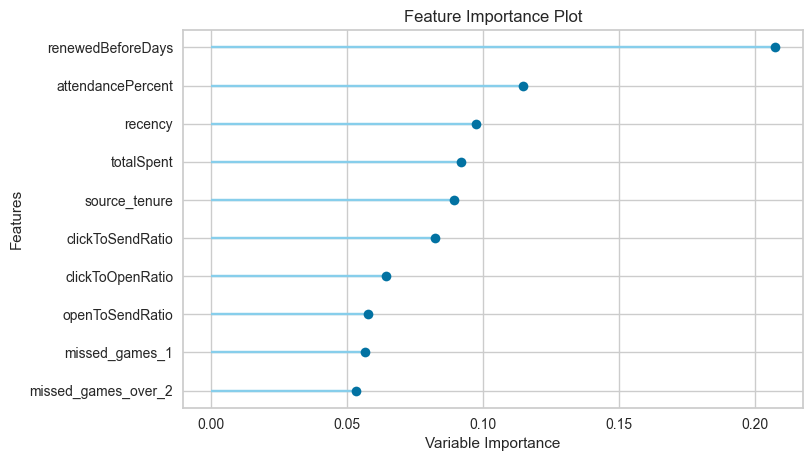

In [32]:
plot_model(best_model, plot='feature')

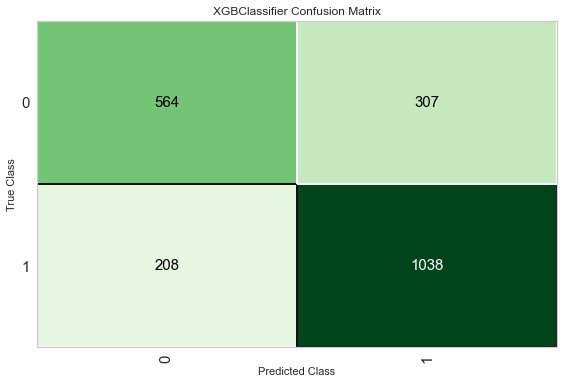

In [33]:
plot_model(best_model, plot='confusion_matrix')

## Observations
Here you can document some ideas on the results from above

## Conclusions
Here you can talk about next steps, did the experiment work? If yes, what to do next? If no, why?